# Vehicle Detection and Tracking

In [1]:
# Import all needed packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import time
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from moviepy.editor import VideoFileClip

### Color Histogram Features

In [547]:
# Define a function to compute color histogram features  
def color_hist_plot(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], nbins)
    ghist = np.histogram(image[:,:,1], nbins)
    bhist = np.histogram(image[:,:,2], nbins)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

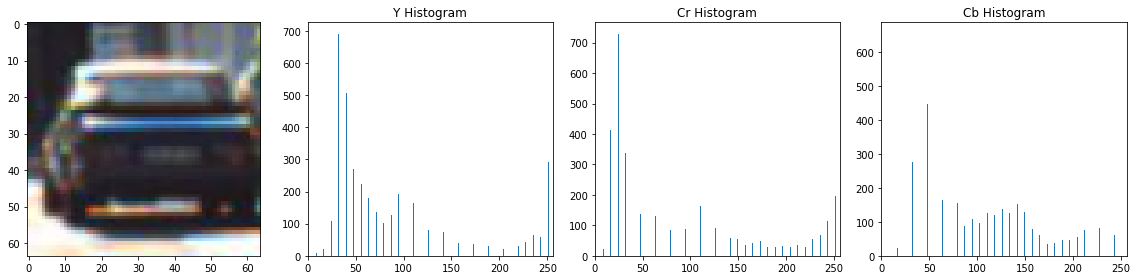

In [548]:
# Example of one sample image color histogram 
image = mpimg.imread('./vehicles_smallset/cars1/1.jpeg')
image1 = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
rh, gh, bh, bincen, feature_vec = color_hist_plot(image1, nbins=32)

fig = plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('Y Histogram')
plt.subplot(143)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('Cr Histogram')
plt.subplot(144)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('Cb Histogram')
fig.tight_layout()

### HOG Features

In [549]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    # TODO: Complete the function body and returns
    hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys")
                          
    return hog_features, hog_image

Text(0.5,1,'HOG Visualization 2')

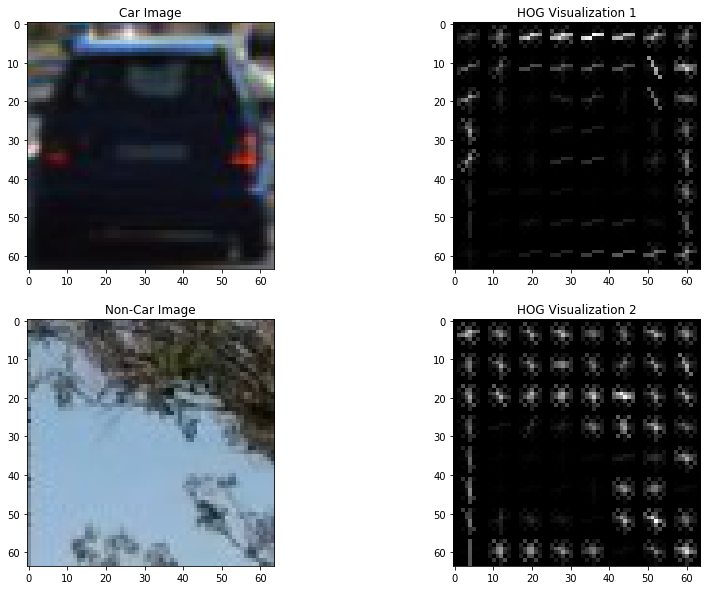

In [550]:
# Load and convert images
image1 = mpimg.imread('./vehicles_smallset/cars1/3.jpeg')
gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2 = mpimg.imread('./non-vehicles_smallset/notcars1/extra03.jpeg')
gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features1, hog_image1 = get_hog_features(gray1, orient= 9, pix_per_cell= 8, 
                                         cell_per_block= 2, vis=True, 
                                         feature_vec=False)
features2, hog_image2 = get_hog_features(gray2, orient= 9, pix_per_cell= 8, 
                                         cell_per_block= 2, vis=True, 
                                         feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(14,10))
plt.subplot(221)
plt.imshow(image1)
plt.title('Car Image')
plt.subplot(222)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization 1')
plt.subplot(223)
plt.imshow(image2)
plt.title('Non-Car Image')
plt.subplot(224)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization 2')

### Functions for Features Extraction

In [12]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=11, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Load vehicle and non-vehicle images

In [13]:
#vehicles = glob.glob('./vehicles_smallset/*/*.jpeg')
#non_vehicles = glob.glob('./non-vehicles_smallset/*/*.jpeg')
vehicles = glob.glob('./vehicles/*/*.*')
non_vehicles = glob.glob('./non-vehicles/*/*.*')

print("Number of vehicle images: {}".format(len(vehicles)))
print("Number of non-vehicle images:{}".format(len(non_vehicles)))

Number of vehicle images: 8792
Number of non-vehicle images:8968


### Get Training Data Features

In [14]:
# Feature Extractoin attributes
color_space = 'YCrCb' # Color Space RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = 16
histbin = 32
hog_chan = 'ALL'

t=time.time()
# Vehicles features
car_features = extract_features(vehicles, color_space=color_space, spatial_size=(spatial, spatial), 
                                hist_bins=histbin,
                                hog_channel=hog_chan)
# Non-vehicles features
notcar_features = extract_features(non_vehicles, color_space=color_space, spatial_size=(spatial, spatial), 
                                   hist_bins=histbin, 
                                   hog_channel=hog_chan)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to get features...')

202.36 Seconds to get features...


In [15]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
#X_scaler = StandardScaler().fit(X_train)
X_scaler = RobustScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 7332


### Train Classifier

In [16]:
# Use a linear SVC 
svc = LinearSVC(C=1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

9.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


In [40]:
# Save model params
data={'svc': svc, 'X_scaler': X_scaler}

with open('model-params.pk', 'wb') as pfile:
    pickle.dump(data, pfile)

In [41]:
## Load model params
with open('model-params.pk', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    svc = pickle_data['svc']
    X_scaler = pickle_data['X_scaler']

### Functions for Car Searching

In [22]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, 
              cell_per_block=2, spatial_size=(32,32), hist_bins=32, cells_per_step=2):
    
    boxes = []
    draw_img = np.copy(img)
    # Because using png images for the fitting and predict jpg image
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return boxes

# Convert color format
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'Non':
        return img
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=4):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Makes a copy of image with all values equal to 0
    heatmap=np.zeros_like(heatmap[:,:,0])
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap1 = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap1[heatmap1 <= threshold] = 0
    # Return thresholded map
    return heatmap1

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

### Sample Images of Found Cars and Heat Map

In [32]:
# Postion vectors
ystarts = [410, 400, 400]
ystops = [480, 550, 620]
# Scale vector
scales = [0.8, 1.5, 2]
cps = [1, 2, 2]
# Color hist and HOG parameters
orient = 11
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 32

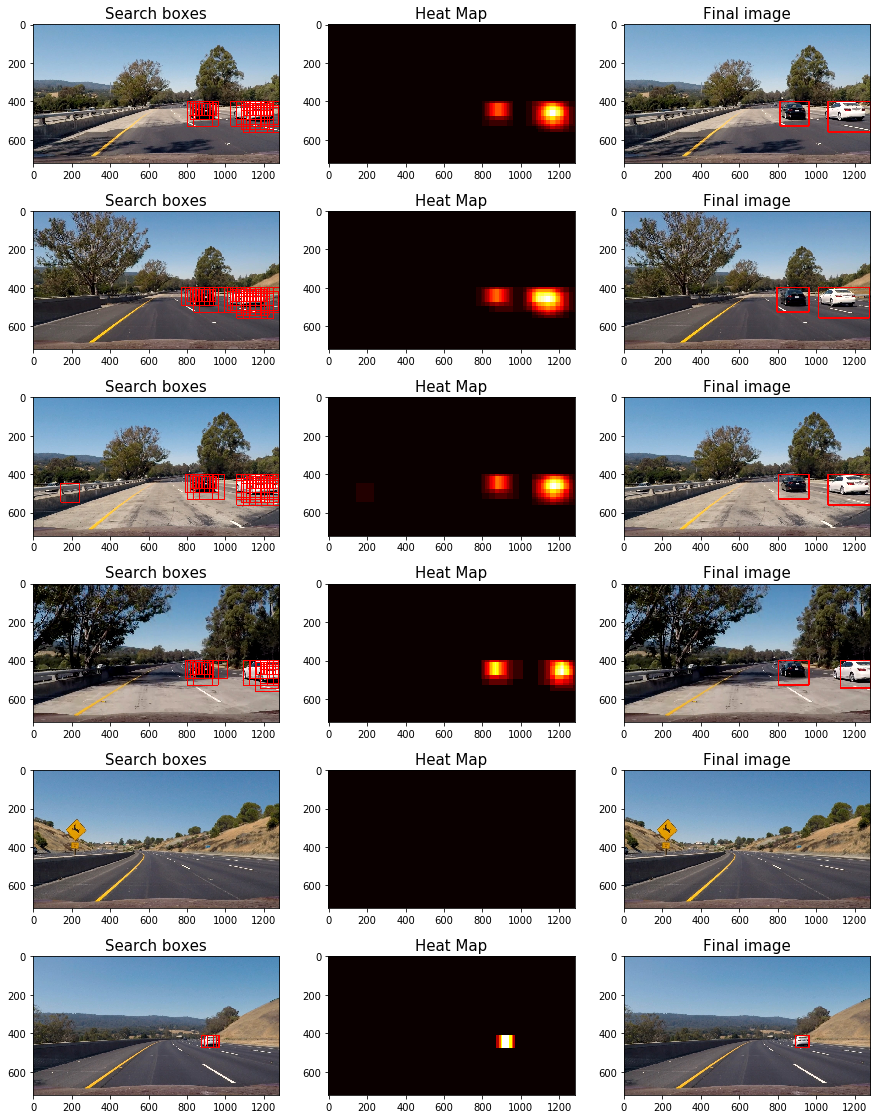

In [27]:
# Plot images with found cars
test_cars = glob.glob('./test_images/*.*')
image_num = len(test_cars)
fig=plt.figure(figsize=(15, 20))

for idx, test_car in enumerate(test_cars):
    # Read image
    img = mpimg.imread(test_car)
    boxes = []
    for scale, ystart, ystop, c in zip(scales, ystarts, ystops, cps):
        boxes_each = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, hist_bins, c)
        boxes.extend(boxes_each)
    
    fig.add_subplot(image_num, 3, idx*3+1)
    out_img = draw_boxes(img, boxes)
    plt.imshow(out_img)
    plt.title("Search boxes", fontsize=15)
    
    fig.add_subplot(image_num, 3, idx*3+2)
    heated=add_heat(img, boxes)
    plt.imshow(heated, cmap='hot')
    plt.title("Heat Map", fontsize=15)
    
    fig.add_subplot(image_num, 3, idx*3+3)
    heated_thres = apply_threshold(heated, 1)
    labels = label(heated_thres)
    final_image = draw_labeled_bboxes(np.copy(img), labels)
    plt.imshow(final_image)
    plt.title("Final image", fontsize=15)

### Final Pipeline

In [6]:
class vehicleTracker():
    def __init__(self):
        self.heatmap = []
        self.ave_heatmap = 0

car = vehicleTracker()

In [45]:
def video_process(image):
    boxes = []
    for scale, ystart, ystop, c in zip(scales, ystarts, ystops, cps):
        boxes_each = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                      cell_per_block, spatial_size, hist_bins, c)
        boxes.extend(boxes_each)

    out_img = draw_boxes(image, boxes)
    heated = add_heat(image, boxes)
    heated_thres = apply_threshold(heated, 2)
 
    car.heatmap.append(heated_thres)
    if len(car.heatmap) > 10:
        car.heatmap.pop(0)
    heatmap_sum = np.sum(car.heatmap, axis=0)
    heatmap_final = apply_threshold(heatmap_sum, len(car.heatmap)*1)
    if len(car.heatmap) == 1:
        car.ave_heatmap = heatmap_final
    else:
        car.ave_heatmap = car.ave_heatmap*0.5 + heatmap_final*0.5/len(car.heatmap)
    
    h_final = apply_threshold(car.ave_heatmap, 1)
    labels = label(h_final)
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    
    return final_image

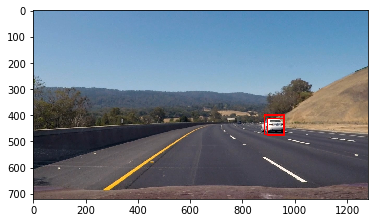

In [39]:
car = vehicleTracker()
img = mpimg.imread('./test_images/test3.jpg')
#img = mpimg.imread('./output_images/39.1.jpg')
out = video_process(img)
plt.imshow(out)

### Video Output

In [ ]:
car = vehicleTracker()

# video processing
output = 'output_videos/project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(video_process)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


  1%|          | 7/1261 [00:10<32:12,  1.54s/it]